### Model 2 Deep PyTorch classifier for sg_encoded (crystal space‑group) labels.

In [1]:
import math, pickle, warnings
from pathlib import Path
import os, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_recall_fscore_support,
                             mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score,f1_score)
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_tabnet.tab_model import TabNetRegressor
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
SEED = 1
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
def set_seed(seed=1):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(SEED)

CSV_PATH   = "./data/processed_csv.csv"
TARGET     = "sg_encoded"
DROP_COLS  = ["file"]
TEST_SIZE  = 0.20

df = pd.read_csv(CSV_PATH)

X = df.drop(columns=[TARGET] + DROP_COLS, errors="ignore")\
      .select_dtypes(include=[np.number])
y_raw = df[TARGET]

counts = y_raw.value_counts()
mask   = y_raw.isin(counts[counts >= 2].index)
X, y_raw = X[mask], y_raw[mask]

enc = LabelEncoder()
y = enc.fit_transform(y_raw)
class_names = enc.classes_
n_classes   = len(class_names)

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=TEST_SIZE, stratify=y, random_state=42)

scaler  = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

n_features = X_train.shape[1]

In [5]:
class DeepFCNet(nn.Module):
    def __init__(self, in_feats, out_classes, p_drop=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_feats, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p_drop),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p_drop / 1.5),

            nn.Linear(128, out_classes)
        )
    def forward(self, x): return self.net(x)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = DeepFCNet(n_features, n_classes).to(device)

In [7]:
EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

hist = {"tr_loss":[], "va_loss":[], "tr_acc":[], "va_acc":[]}

for epoch in range(1, EPOCHS+1):
    model.train()
    tl, tc, tn = 0., 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward(); optimizer.step()
        tl += loss.item()*xb.size(0)
        tc += (logits.argmax(1)==yb).sum().item()
        tn += xb.size(0)
    model.eval()
    vl, vc, vn = 0., 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb); loss = criterion(logits, yb)
            vl += loss.item()*xb.size(0)
            vc += (logits.argmax(1)==yb).sum().item()
            vn += xb.size(0)
    hist["tr_loss"].append(tl/tn); hist["va_loss"].append(vl/vn)
    hist["tr_acc"].append(tc/tn);  hist["va_acc"].append(vc/vn)
    if epoch==1 or epoch%10==0:
        print(f"Epoch {epoch:3}/{EPOCHS} | "
              f"val_acc={hist['va_acc'][-1]:.4f}  val_loss={hist['va_loss'][-1]:.4f}")


Epoch   1/100 | val_acc=0.6351  val_loss=1.3504
Epoch  10/100 | val_acc=0.7737  val_loss=0.6179
Epoch  20/100 | val_acc=0.8020  val_loss=0.4984
Epoch  30/100 | val_acc=0.8260  val_loss=0.4765
Epoch  40/100 | val_acc=0.8397  val_loss=0.4331
Epoch  50/100 | val_acc=0.8392  val_loss=0.4420
Epoch  60/100 | val_acc=0.8441  val_loss=0.4340
Epoch  70/100 | val_acc=0.8437  val_loss=0.4471
Epoch  80/100 | val_acc=0.8477  val_loss=0.4423
Epoch  90/100 | val_acc=0.8556  val_loss=0.4586
Epoch 100/100 | val_acc=0.8512  val_loss=0.4485


In [8]:
model.eval()
y_pred = []
with torch.no_grad():
    for xb, _ in test_loader:
        y_pred.append(model(xb.to(device)).argmax(1).cpu())
y_pred = torch.cat(y_pred).numpy()

print("\n=== Weighted classification report ===")
print(classification_report(y_test, y_pred, zero_division=0))

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_test, y_pred, average="weighted", zero_division=0)
print(f"Accuracy : {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")



=== Weighted classification report ===
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           3       0.79      0.79      0.79        14
           4       0.95      0.96      0.96       167
           5       0.64      0.64      0.64        14
           6       0.83      0.91      0.87        22
           7       0.00      0.00      0.00         1
           9       0.75      1.00      0.86         6
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       1.00      0.50      0.67         2
          13       0.50      0.33      0.40         3
          14       0.50      1.00      0.67         3
          15       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         1
          18       0.40      1.00      0.57         2
          19       0.67      1.00      0.80         2
          20       1.00      0.89      0.

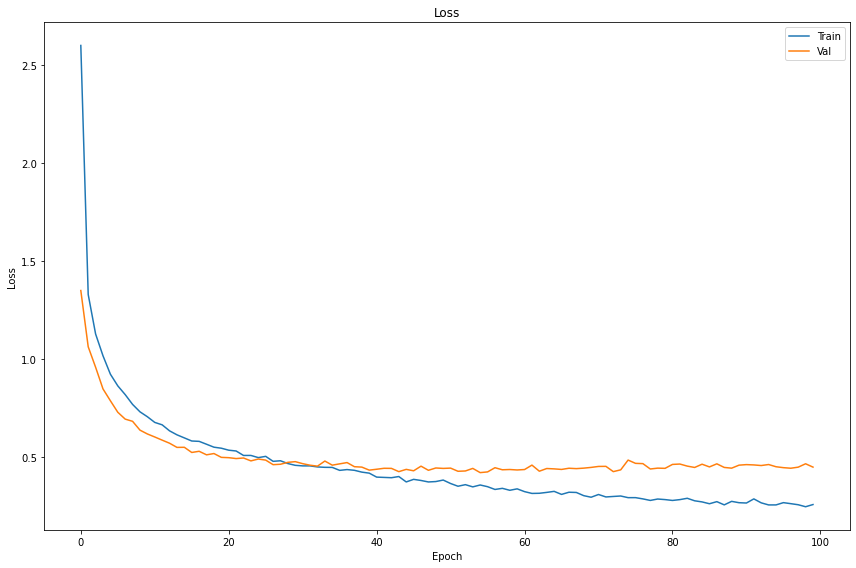

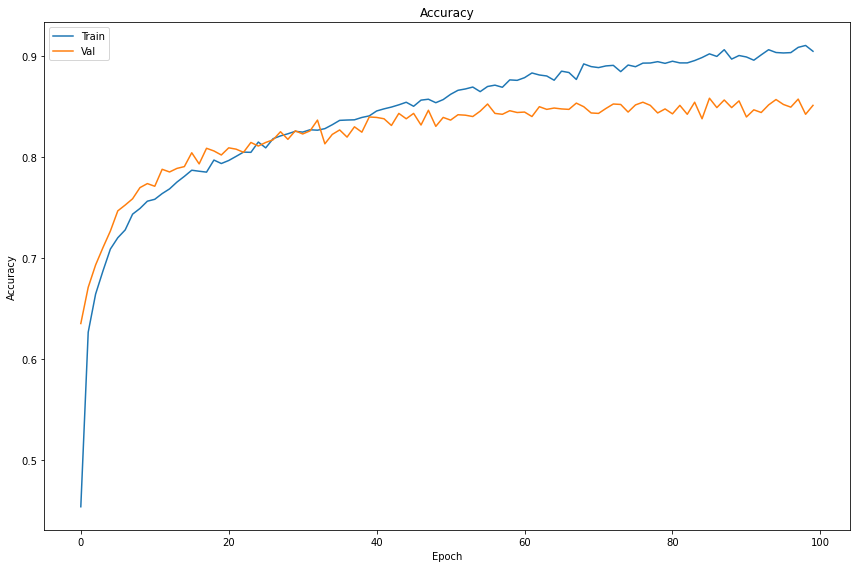

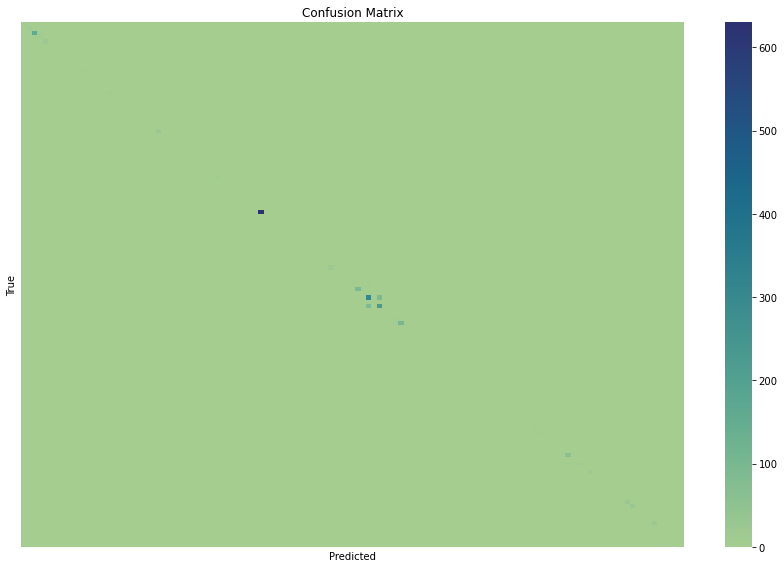

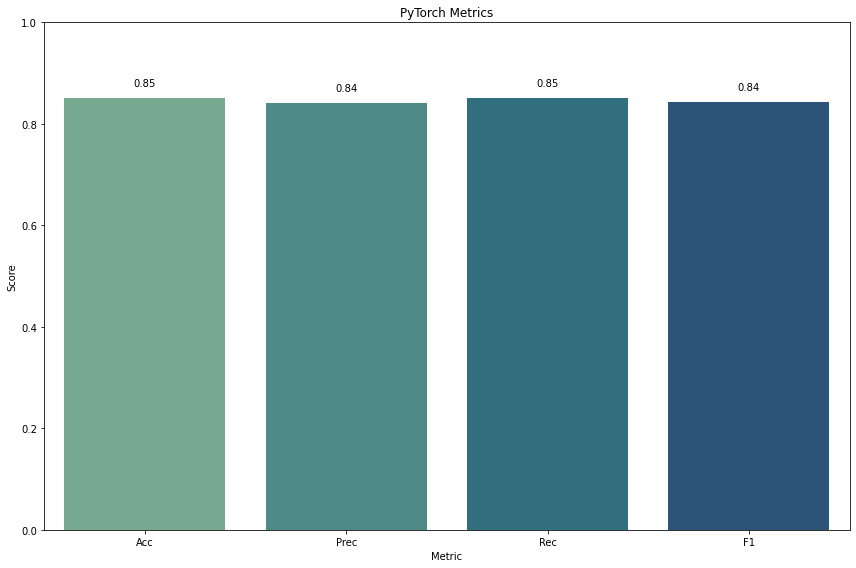

In [9]:
# Loss plot
plt.figure(figsize=(12, 8))
plt.plot(hist["tr_loss"], label="Train")
plt.plot(hist["va_loss"], label="Val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy plot
plt.figure(figsize=(12, 8))
plt.plot(hist["tr_acc"], label="Train")
plt.plot(hist["va_acc"], label="Val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, cmap="crest", fmt="d", annot=False,
            xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# PyTorch Metrics Bar Plot
plt.figure(figsize=(12, 8))
metrics = [acc, prec, rec, f1]
labels = ["Acc", "Prec", "Rec", "F1"]

ax = sns.barplot(x=labels, y=metrics, palette="crest")
plt.ylim(0, 1)
plt.title("PyTorch Metrics")
plt.xlabel("Metric")
plt.ylabel("Score")

for i, val in enumerate(metrics):
    ax.text(i, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
parent_dir    = "Models"
model_name    = "Model 2"
model_dir     = os.path.join(parent_dir, model_name)

try:
    os.mkdir(parent_dir)
    print(f"Directory '{parent_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{parent_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{parent_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")

try:
    os.mkdir(model_dir)
    print(f"Directory '{model_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{model_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{model_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")

torch.save(
    model.state_dict(),
    os.path.join(model_dir, f"{model_name} spacegroup.pt")
)

print(f"\nSaved files to '{model_dir}':")
print(f"  - {model_name} spacegroup.pt")
print(f"  - {model_name} volume_regressor.pt")
print(f"  - {model_name} preprocessing.pkl")

Directory 'Models' already exists.
Directory 'Models\Model 2' created successfully.

Saved files to 'Models\Model 2':
  - Model 2 spacegroup.pt
  - Model 2 volume_regressor.pt
  - Model 2 preprocessing.pkl
